# Dog breed Classifier

In this notebook, we have implemented the dog breed classifier, from their images. The dataset have been taken from the aws datasets "https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip"

This dataset consists of 133 dog breeds



In [12]:
# TODO: Install any packages that you might need
# For instance, you will need the smdebug package
!pip install smdebug

Looking in indexes: https://pypi.org/simple, https://pip.repos.neuron.amazonaws.com


In [13]:
# TODO: Import any packages that you might need
# For instance you will need Boto3 and Sagemaker
import os
import sagemaker
import boto3
from sagemaker.session import Session
from sagemaker import get_execution_role

## Dataset
TODO: Explain what dataset you are using for this project. Maybe even give a small overview of the classes, class distributions etc that can help anyone not familiar with the dataset get a better understand of it.

In [14]:
Command to download and unzip data

!wget https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/dogImages.zip
!unzip dogImages.zip  > /dev/null

In [15]:
TODO: Fetch and upload the data to AWS S3

bucket = sagemaker.Session().default_bucket()
path_to_s3 = sagemaker.Session().upload_data(path="dogImages", bucket=bucket, key_prefix="Datasets")

## Hyperparameter Tuning
**TODO:** This is the part where you will finetune a pretrained model with hyperparameter tuning. Remember that you have to tune a minimum of two hyperparameters. However you are encouraged to tune more. You are also encouraged to explain why you chose to tune those particular hyperparameters and the ranges.

**Note:** You will need to use the `hpo.py` script to perform hyperparameter tuning.

In [17]:
#TODO: Declare your HP ranges, metrics etc.
from sagemaker.tuner import (
    IntegerParameter,
    CategoricalParameter,
    ContinuousParameter,
    HyperparameterTuner,
)

hyperparameter_ranges = {
    "lr": ContinuousParameter(0.01, 0.1),
    "batch-size": CategoricalParameter([ 64, 128, 256])
}

In [18]:
#TODO: Create estimators for your HPs

from  sagemaker.pytorch import PyTorch
from  sagemaker import get_execution_role

estimator = PyTorch(
    entry_point="hpo.py",
    role=get_execution_role(),
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large",
    base_job_name = "hps-for-SpeciesClassifier"
)

objective_type = "Minimize"
objective_metric_name = "average test loss"
metric_definitions = [{"Name": "average test loss", "Regex": "Test set: Average loss: ([0-9\\.]+)"}]

tuner = HyperparameterTuner(
    estimator,
    objective_metric_name,
    hyperparameter_ranges,
    metric_definitions,
    max_jobs=10,
    max_parallel_jobs=4,
    objective_type=objective_type, 
    early_stopping_type="Auto"
)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


In [19]:
# TODO: Fit your HP Tuner
tuner.fit({"train" : path_to_s3}, wait = True) # TODO: Remember to include your data channels

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................!


In [19]:
best_estimator = tuner.best_estimator()  # TODO: Get the best estimators and the best HPs

hyperparameters = best_estimator.hyperparameters() # Get the hyperparameters of the best trained model

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole



2023-03-04 15:07:13 Starting - Found matching resource for reuse
2023-03-04 15:07:13 Downloading - Downloading input data
2023-03-04 15:07:13 Training - Training image download completed. Training in progress.
2023-03-04 15:07:13 Uploading - Uploading generated training model
2023-03-04 15:07:13 Completed - Resource released due to keep alive period expiry


## Model Profiling and Debugging
TODO: Using the best hyperparameters, create and finetune a new model

**Note:** You will need to use the `train_model.py` script to perform model profiling and debugging.

In [20]:
# TODO: Set up debugging and profiling rules and hooks
from sagemaker.debugger import Rule, ProfilerRule, rule_configs
from sagemaker.debugger import DebuggerHookConfig, ProfilerConfig, FrameworkProfile, CollectionConfig

rules = [
    Rule.sagemaker(rule_configs.loss_not_decreasing()),
    ProfilerRule.sagemaker(rule_configs.LowGPUUtilization()),
    ProfilerRule.sagemaker(rule_configs.ProfilerReport()),
    Rule.sagemaker(rule_configs.vanishing_gradient()),
    Rule.sagemaker(rule_configs.overfit()),
    Rule.sagemaker(rule_configs.overtraining()),
    Rule.sagemaker(rule_configs.poor_weight_initialization()),
]

profiler_config = ProfilerConfig(
    system_monitor_interval_millis=500, framework_profile_params=FrameworkProfile(num_steps=10)
)

debugger_config = DebuggerHookConfig(
    hook_parameters={"train.save_interval": "100", "eval.save_interval": "10"}
)

collection_configs=[CollectionConfig(name="CrossEntropyLoss_output_0",parameters={
    "include_regex": "CrossEntropyLoss_output_0", "train.save_interval": "10","eval.save_interval": "1"})]


In [22]:
# TODO: Create and fit an estimator

hyperparameters={'batch_size': int(best_estimator.hyperparameters()['batch_size'].replace('"', "")),
                      'learning_rate': best_estimator.hyperparameters()['learning_rate']}

estimator = PyTorch(
    entry_point="train_model.py",
    role=get_execution_role(),
    py_version='py36',
    framework_version="1.8",
    instance_count=1,
    instance_type="ml.m5.large",
    hyperparameters=hyperparameters,
    profiler_config=profiler_config,
    debugger_hook_config=debugger_config,
    rules=rules
)

estimator.fit({'train' : path_to_s3 },wait=True)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: pytorch-training-2023-03-07-03-07-05-436


2023-03-07 03:07:05 Starting - Starting the training job...
2023-03-07 03:07:28 Starting - Preparing the instances for trainingLossNotDecreasing: InProgress
VanishingGradient: InProgress
Overfit: InProgress
Overtraining: InProgress
PoorWeightInitialization: InProgress
LowGPUUtilization: InProgress
ProfilerReport: InProgress
......
2023-03-07 03:08:24 Downloading - Downloading input data.........
2023-03-07 03:10:05 Training - Downloading the training image...
2023-03-07 03:10:25 Training - Training image download completed. Training in progress.bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2023-03-07 03:10:23,699 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2023-03-07 03:10:23,702 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-03-07 03:10:23,710 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
20

In [23]:
# TODO: Plot a debugging output.

from smdebug.trials import create_trial
from smdebug.core.modes import ModeKeys
from smdebug.profiler.analysis.notebook_utils.training_job import TrainingJob
from smdebug.profiler.analysis.notebook_utils.timeline_charts import TimelineCharts

session = boto3.session.Session()
region = session.region_name

training_job_name = estimator.latest_training_job.name
print(f"Training jobname: {training_job_name}")
print(f"Region: {region}")

trial = create_trial(estimator.latest_job_debugger_artifacts_path())

print(trial.tensor_names())
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.TRAIN)))
print(len(trial.tensor("CrossEntropyLoss_output_0").steps(mode=ModeKeys.EVAL)))

tj = TrainingJob(training_job_name, region)
tj.wait_for_sys_profiling_data_to_be_available()

system_metrics_reader = tj.get_systems_metrics_reader()
system_metrics_reader.refresh_event_file_list()

view_timeline_charts = TimelineCharts(
    system_metrics_reader,
    framework_metrics_reader=None,
    select_dimensions=["CPU", "GPU"],
    select_events=["total"],
)

[2023-03-07 03:46:19.570 ip-172-16-64-116.ec2.internal:8160 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None


Training jobname: pytorch-training-2023-03-07-03-07-05-436
Region: us-east-1
[2023-03-07 03:46:21.090 ip-172-16-64-116.ec2.internal:8160 INFO s3_trial.py:42] Loading trial debug-output at path s3://sagemaker-us-east-1-602696814187/pytorch-training-2023-03-07-03-07-05-436/debug-output


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


[2023-03-07 03:46:21.515 ip-172-16-64-116.ec2.internal:8160 INFO trial.py:198] Training has ended, will refresh one final time in 1 sec.
[2023-03-07 03:46:22.532 ip-172-16-64-116.ec2.internal:8160 INFO trial.py:210] Loaded all steps
['CrossEntropyLoss_output_0', 'gradient/ResNet_fc.0.bias', 'gradient/ResNet_fc.0.weight', 'gradient/ResNet_fc.2.bias', 'gradient/ResNet_fc.2.weight', 'layer1.0.relu_input_0', 'layer1.0.relu_input_1', 'layer1.0.relu_input_2', 'layer1.1.relu_input_0', 'layer1.1.relu_input_1', 'layer1.1.relu_input_2', 'layer1.2.relu_input_0', 'layer1.2.relu_input_1', 'layer1.2.relu_input_2', 'layer2.0.relu_input_0', 'layer2.0.relu_input_1', 'layer2.0.relu_input_2', 'layer2.1.relu_input_0', 'layer2.1.relu_input_1', 'layer2.1.relu_input_2', 'layer2.2.relu_input_0', 'layer2.2.relu_input_1', 'layer2.2.relu_input_2', 'layer2.3.relu_input_0', 'layer2.3.relu_input_1', 'layer2.3.relu_input_2', 'layer3.0.relu_input_0', 'layer3.0.relu_input_1', 'layer3.0.relu_input_2', 'layer3.1.relu_in

**TODO**: Is there some anomalous behaviour in your debugging output? If so, what is the error and how will you fix it?  
**Answer**: Yes, there is an anomalous behaviour in the debugging output, the CPU utilization spikes at regular intervals of time. I guess that we can solve this error by using an instance with litle more CPU cores, so it could handle out the pressure evenly. 

In [24]:
# TODO: Display the profiler output

rule_output_path = estimator.output_path + estimator.latest_training_job.job_name + "/rule-output"
print(f"The profiler report is stored at {rule_output_path}")

! aws s3 ls {rule_output_path} --recursive
! aws s3 cp {rule_output_path} ./ --recursive

# get the autogenerated folder name of profiler report
profiler_report_name = [
    rule["RuleConfigurationName"]
    for rule in estimator.latest_training_job.rule_job_summary()
    if "Profiler" in rule["RuleConfigurationName"]
][0]

The profiler report is stored at s3://sagemaker-us-east-1-602696814187/pytorch-training-2023-03-07-03-07-05-436/rule-output
2023-03-07 03:45:41     375104 pytorch-training-2023-03-07-03-07-05-436/rule-output/ProfilerReport/profiler-output/profiler-report.html
2023-03-07 03:45:40     223012 pytorch-training-2023-03-07-03-07-05-436/rule-output/ProfilerReport/profiler-output/profiler-report.ipynb
2023-03-07 03:45:35        192 pytorch-training-2023-03-07-03-07-05-436/rule-output/ProfilerReport/profiler-output/profiler-reports/BatchSize.json
2023-03-07 03:45:35        200 pytorch-training-2023-03-07-03-07-05-436/rule-output/ProfilerReport/profiler-output/profiler-reports/CPUBottleneck.json
2023-03-07 03:45:35       1964 pytorch-training-2023-03-07-03-07-05-436/rule-output/ProfilerReport/profiler-output/profiler-reports/Dataloader.json
2023-03-07 03:45:35        127 pytorch-training-2023-03-07-03-07-05-436/rule-output/ProfilerReport/profiler-output/profiler-reports/GPUMemoryIncrease.json
20

**PROFILER REPORT**: The profiler report of this project is displayed below

In [25]:
import IPython

IPython.display.HTML(filename=profiler_report_name + "/profiler-output/profiler-report.html")

## Model Deploying

In [27]:
# TODO: Deploy your model to an endpoint
from sagemaker.predictor import Predictor

jpeg_serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")
json_deserializer = sagemaker.deserializers.JSONDeserializer()

class ImagePredictor(Predictor):
    def __init__(self, endpoint_name, sagemaker_session):
        super(ImagePredictor, self).__init__(
            endpoint_name,
            sagemaker_session=sagemaker_session,
            serializer=jpeg_serializer,
            deserializer=json_deserializer
        )


In [28]:
predictor=estimator.deploy(initial_instance_count=1, instance_type="ml.m5.xlarge") # TODO: Add your deployment configuration like instance type and number of instances

INFO:sagemaker:Creating model with name: pytorch-training-2023-03-07-03-48-14-740
INFO:sagemaker:Creating endpoint-config with name pytorch-training-2023-03-07-03-48-14-740
INFO:sagemaker:Creating endpoint with name pytorch-training-2023-03-07-03-48-14-740


-----!

In [33]:
# TODO: Run an prediction on the endpoint

with open("Golden Retriever.jpg", "rb") as image:
    f = image.read()

image = bytearray(f)  # TODO: Your code to load and preprocess image to send to endpoint for prediction

## Displaying the Test image

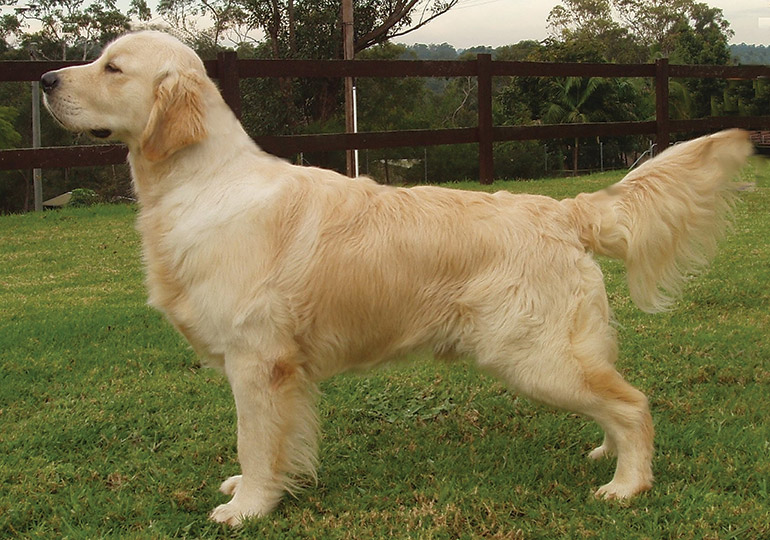

In [34]:
from PIL import Image
import io
Image.open(io.BytesIO(image))

## Predicting the test image

In [35]:
response = (predictor.predict(image))

predicted_label = (np.argmax(response, axis=-1)[0]) + 1

predicted_label

56


In [36]:
# TODO: Remember to shutdown/delete your endpoint once your work is done
predictor.delete_endpoint()

INFO:sagemaker:Deleting endpoint configuration with name: pytorch-training-2023-03-07-03-48-14-740
INFO:sagemaker:Deleting endpoint with name: pytorch-training-2023-03-07-03-48-14-740
